In [2]:
!pip install tqdm

%load_ext autoreload
import numpy as np
import arms
import UCB
import matplotlib.pyplot as plt
from tqdm import tqdm
%autoreload 2

gdax 1.0.6 has requirement websocket-client==0.40.0, but you'll have websocket-client 0.47.0 which is incompatible.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


## 1. Stochastic Multi-Armed Bandits on Simulated Data

## 1.1. Bernoulli bandit models

In [34]:
def kl(x,y):
    return x*np.log(x/y)+(1-x)*np.log((1-x)/(1-y))

def compute_complexity(mu_max, means):
    C_p = sum([(mu_max-mean)/kl(mean, mu_max) for mean in means if mean < mu_max])
    return C_p


In [48]:
# Bernoulli bandit models
arm1 = arms.ArmBernoulli(0.30, random_state=np.random.randint(1, 312414))
arm2 = arms.ArmBernoulli(0.25, random_state=np.random.randint(1, 312414))
arm3 = arms.ArmBernoulli(0.20, random_state=np.random.randint(1, 312414))
arm4 = arms.ArmBernoulli(0.10, random_state=np.random.randint(1, 312414))
arm5 = arms.ArmBernoulli(0.90, random_state=np.random.randint(1, 312414))
arm6 = arms.ArmBernoulli(0.70, random_state=np.random.randint(1, 312414))

# MAB problem (more complex)
MAB1 = [arm1, arm2, arm3, arm4]
nb_arms1 = len(MAB1)
means1 = [el.mean for el in MAB1]

# MAB problem (less complex)
MAB2 = [arm5, arm6, arm2, arm3]
nb_arms2 = len(MAB)
means2 = [el.mean for el in MAB2]

# Display the means of your bandit (to find the best)
print('Problem 1: means: {}'.format(means1))
print('Problem 2: means: {}'.format(means2))

mu_max1 = np.max(means1)
mu_max2 = np.max(means2)

# Comparison of the regret on one run of the bandit algorithm
T = 3000  # horizon
ro = 0.2  # exporation coefficient

# Complexity
c1 = compute_complexity(mu_max1, means1)
c2 = compute_complexity(mu_max2, means2)
print('Problem 1: complexity: {}'.format(c1))
print('Problem 2: complexity: {}'.format(c2))


Problem 1: means: [0.3, 0.25, 0.2, 0.1]
Problem 2: means: [0.9, 0.7, 0.25, 0.2]
Problem 1: complexity: 13.716834447860332
Problem 2: complexity: 2.361001975303455


In [16]:
# One run analysis

# Defining UCB1, Thompson sampling and naive strategies
strat1 = UCB.UCB(T, MAB1, ro)
strat2 = UCB.UCB(T, MAB1, ro)
strat3 = UCB.UCB(T, MAB1, ro)

mode1, mode2, mode3 = 'UCB1', 'TS', 'naive'
rew1, draws1 = strat1.run(mode1)
rew2, draws2 = strat2.run(mode2)
rew3, draws3 = strat3.run(mode3)

In [25]:
bandit_names = [f'bandit_{k}' for k in np.arange(1, nb_arms+1)]
print(f'Number of pulls in strat {mode1}:',dict(zip(bandit_names,strat1.compute_pull_per_arm())))
print(f'Number of pulls in strat {mode2}:', dict(zip(bandit_names,strat2.compute_pull_per_arm())))
print(f'Number of pulls in strat {mode3}:', dict(zip(bandit_names,strat3.compute_pull_per_arm())))

Number of pulls in strat UCB1: {'bandit_1': 2950, 'bandit_2': 2, 'bandit_3': 2, 'bandit_4': 46}
Number of pulls in strat TS: {'bandit_1': 2789, 'bandit_2': 105, 'bandit_3': 57, 'bandit_4': 49}
Number of pulls in strat naive: {'bandit_1': 2997, 'bandit_2': 1, 'bandit_3': 1, 'bandit_4': 1}


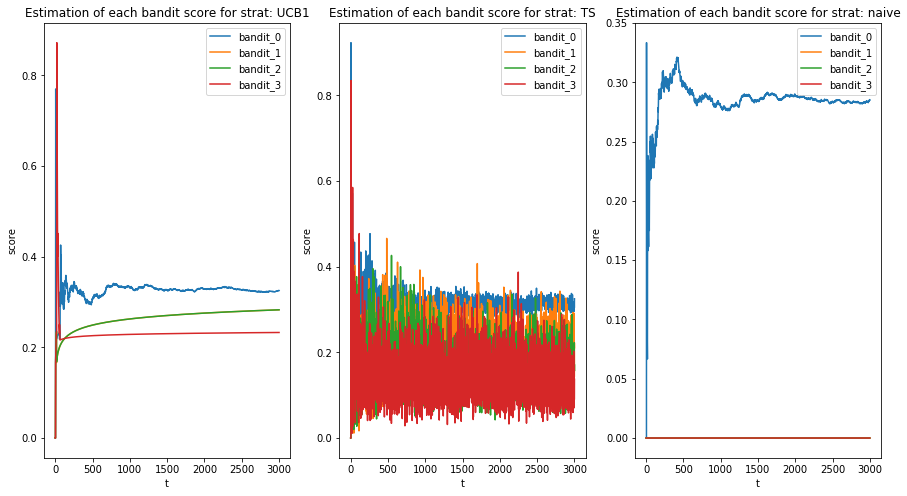

In [27]:
# Estimation of each bandit score for different strategies
f,ax = plt.subplots(1,3, figsize = (15,8))
strat1.plot_scores(ax[0], mode1)
strat2.plot_scores(ax[1], mode2)
strat3.plot_scores(ax[2], mode3)


plt.show()

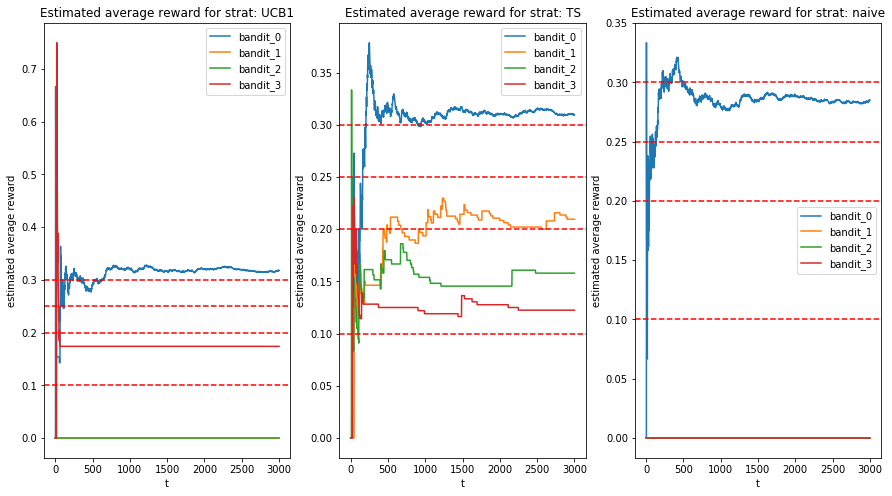

In [29]:
# Estimation of each bandit reward for different strategies

f,ax = plt.subplots(1,3, figsize = (15,8))
strat1.plot_est_means([el.mean for el in MAB], ax[0], mode1)
strat2.plot_est_means([el.mean for el in MAB], ax[1], mode2)
strat3.plot_est_means([el.mean for el in MAB], ax[2], mode3)

plt.show()

In [61]:
T = 8000  # horizon

In [62]:
reg1_MC = np.zeros(T)
reg2_MC = np.zeros(T)
reg3_MC = np.zeros(T)

n_MC_iter = 100

strat1 = UCB.UCB(T, MAB1, ro)
strat2 = UCB.UCB(T, MAB1, ro)
strat3 = UCB.UCB(T, MAB1, ro)
mode1, mode2, mode3 = 'UCB1', 'TS', 'naive'

for i in tqdm(range(n_MC_iter)):
    rew1, draws1 = strat1.run(mode1)
    rew2, draws2 = strat2.run(mode2)
    rew3, draws3 = strat3.run(mode3)
    
    reg1 = mu_max1 * np.arange(1, T + 1) - np.cumsum(rew1)
    reg2 = mu_max1 * np.arange(1, T + 1) - np.cumsum(rew2)
    reg3 = mu_max1 * np.arange(1, T + 1) - np.cumsum(rew3)
    
    reg1_MC = 1/(i+1) * (i*reg1_MC+reg1)
    reg2_MC = 1/(i+1) * (i*reg2_MC+reg2)    
    reg3_MC = 1/(i+1) * (i*reg3_MC+reg3)    

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.59s/it]


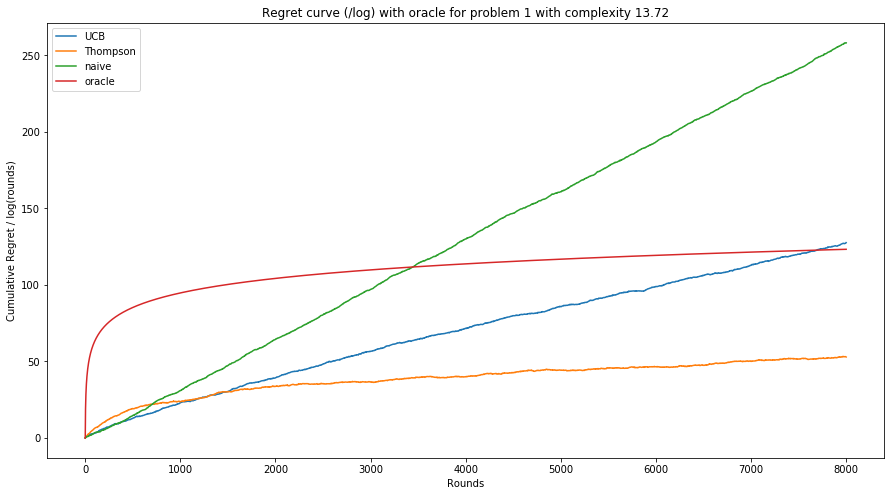

In [63]:
# Problem 1: More complex problem
plt.figure(1, figsize = (15,8))
x = np.arange(1, T+1)
plt.plot(x, reg1_MC, label='UCB')
plt.plot(x, reg2_MC, label='Thompson')
plt.plot(x, reg3_MC, label='naive')
plt.plot(x, C_p*np.log(x), label = 'oracle')

plt.legend()
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.title(f'Regret curve with oracle for problem 1 with complexity {np.round(c1,2)}')

plt.show()


In [64]:
reg1_MC = np.zeros(T)
reg2_MC = np.zeros(T)
reg3_MC = np.zeros(T)

n_MC_iter = 100

strat1 = UCB.UCB(T, MAB2, ro)
strat2 = UCB.UCB(T, MAB2, ro)
strat3 = UCB.UCB(T, MAB2, ro)
mode1, mode2, mode3 = 'UCB1', 'TS', 'naive'

for i in tqdm(range(n_MC_iter)):
    rew1, draws1 = strat1.run(mode1)
    rew2, draws2 = strat2.run(mode2)
    rew3, draws3 = strat3.run(mode3)
    
    reg1 = mu_max2 * np.arange(1, T + 1) - np.cumsum(rew1)
    reg2 = mu_max2 * np.arange(1, T + 1) - np.cumsum(rew2)
    reg3 = mu_max2 * np.arange(1, T + 1) - np.cumsum(rew3)
    
    reg1_MC = 1/(i+1) * (i*reg1_MC+reg1)
    reg2_MC = 1/(i+1) * (i*reg2_MC+reg2)    
    reg3_MC = 1/(i+1) * (i*reg3_MC+reg3)    

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:18<00:00,  1.33s/it]


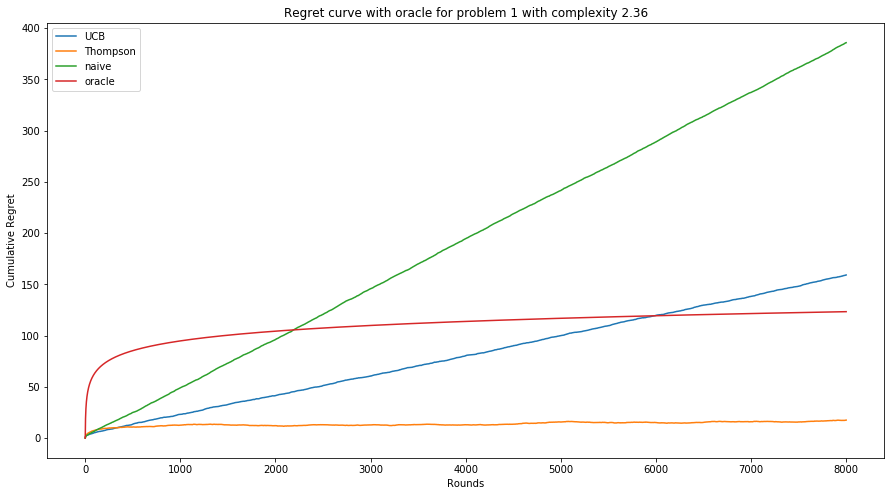

In [66]:
# Problem 1: More complex problem
plt.figure(1, figsize = (15,8))
x = np.arange(1, T+1)
plt.plot(x, reg1_MC, label='UCB')
plt.plot(x, reg2_MC, label='Thompson')
plt.plot(x, reg3_MC, label='naive')
plt.plot(x, C_p*np.log(x), label = 'oracle')

plt.legend()
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.title(f'Regret curve with oracle for problem 1 with complexity {np.round(c2,2)}')

plt.show()


## 1.2. Non-parametric bandits (bounded rewards)

In [71]:
# Bernoulli bandit models
arm1 = arms.ArmBernoulli(0.30, random_state=np.random.randint(1, 312414))
arm2 = arms.ArmBeta(2,10, random_state=np.random.randint(1, 312414))
arm3 = arms.ArmExp(4, random_state=np.random.randint(1, 312414))
arm4 = arms.ArmFinite(np.array([0,0.25, 0.5, 1]), np.array([0.25,0.25,0.25,0.25]), random_state=np.random.randint(1, 312414))

# MAB problem (more complex)
MAB1 = [arm1, arm2, arm3, arm4]
nb_arms1 = len(MAB1)
means1 = [el.mean for el in MAB1]



# Display the means of your bandit (to find the best)
print('Problem 1: means: {}'.format(means1))

mu_max1 = np.max(means1)

# Comparison of the regret on one run of the bandit algorithm
T = 3000  # horizon
ro = 0.2  # exporation coefficient



Problem 1: means: [0.3, 0.16666666666666666, 0.23134263963622598, 0.4375]


In [72]:
reg1_MC = np.zeros(T)
reg2_MC = np.zeros(T)
reg3_MC = np.zeros(T)

n_MC_iter = 100

strat1 = UCB.UCB(T, MAB1, ro)
strat2 = UCB.UCB(T, MAB1, ro)
strat3 = UCB.UCB(T, MAB1, ro)
mode1, mode2, mode3 = 'UCB1', 'TS', 'naive'

for i in tqdm(range(n_MC_iter)):
    rew1, draws1 = strat1.run(mode1)
    rew2, draws2 = strat2.run(mode2)
    rew3, draws3 = strat3.run(mode3)
    
    reg1 = mu_max1 * np.arange(1, T + 1) - np.cumsum(rew1)
    reg2 = mu_max1 * np.arange(1, T + 1) - np.cumsum(rew2)
    reg3 = mu_max1 * np.arange(1, T + 1) - np.cumsum(rew3)
    
    reg1_MC = 1/(i+1) * (i*reg1_MC+reg1)
    reg2_MC = 1/(i+1) * (i*reg2_MC+reg2)    
    reg3_MC = 1/(i+1) * (i*reg3_MC+reg3)    

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.43it/s]


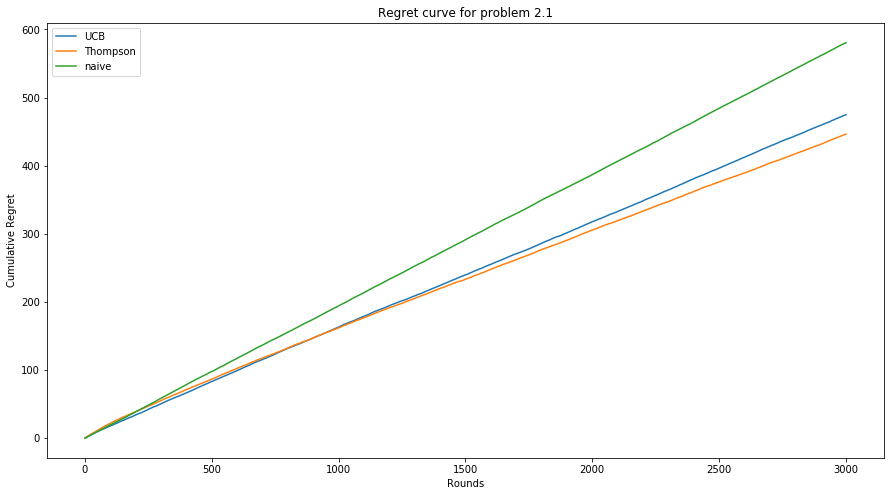

In [75]:
# Problem 1: More complex problem
plt.figure(1, figsize = (15,8))
x = np.arange(1, T+1)
plt.plot(x, reg1_MC, label='UCB')
plt.plot(x, reg2_MC, label='Thompson')
plt.plot(x, reg3_MC, label='naive')

plt.legend()
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.title(f'Regret curve for problem 2.1')

plt.show()
